# Pujol-like shear Calibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
from scipy.optimize import minimize

## Generate Galaxies

In [3]:
def generate_gal(i):
  #cat
  cat = galsim.COSMOSCatalog(sample="25.2")
  gal = cat.makeGalaxy(i, gal_type='parametric')
  gal_mag = cat.param_cat['mag_auto'][cat.orig_index[i]]  
  ##cfis photometry
  mag_zp = 32
  gal_flux = 10**(-(gal_mag-mag_zp)/2.5)
  gal = gal.withFlux(gal_flux)
  return gal

test:

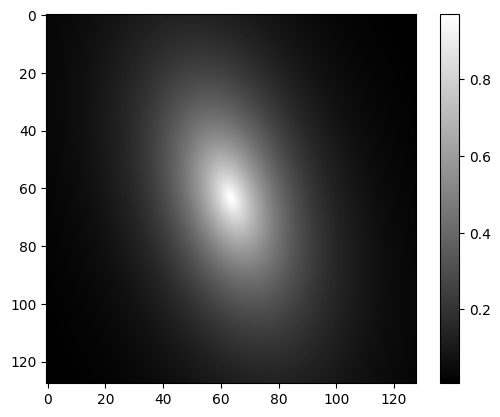

In [4]:
gal = generate_gal(2)
imshow(gal.drawImage(nx=128,ny=128,scale=0.01).array,cmap="gist_gray");colorbar()

## Make noise images

In [5]:
def noise_image(size=51,sky_level=400):
  rng = np.random.RandomState(1)
  noise=rng.normal(loc=sky_level,scale=np.sqrt(sky_level),size=[size,size])
  return noise 

In [6]:
nois = noise_image()

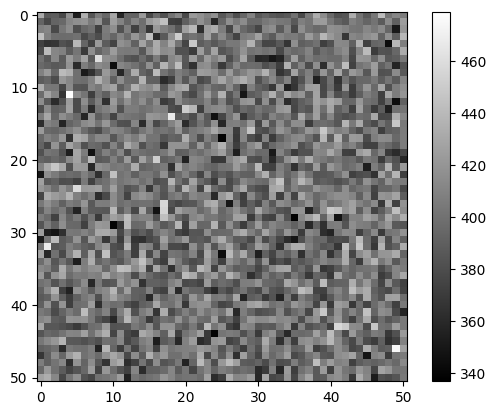

In [7]:
imshow(nois,cmap="gist_gray");colorbar()

## Transform array images into GalSim objects

In [8]:
def galsimator(im_array,scale=.1):
  image = galsim.Image(im_array,scale=scale)
  galsim_img = galsim.InterpolatedImage(image,x_interpolant='lanczos14')
  return galsim_img  

## Measure Ellipticities in Multiple Exposures

In [113]:
def model(flux,half_light_radius,g1,g2,sky_level,psf_objs,boxsize,scale):
  """
  Creates a model to fit on n exposures, 
  number of exposures is defined by how many psfs
  
  flux: float - galaxy flux
  half_light_radius: float - galaxy half light radius 
  g1,g2: galaxy ellipticity
  sky_level: background level of image
  boxsize: stamp size in pixels
  scale: pixel scale
  """
  model_image_list = []
  for psf in psfs:
    

    
    gal = galsim.Gaussian(flux=flux,
      half_light_radius = hlr
    ).shear(
      g1=g1,
      g2=g2
    )

    model = galsim.Convolve([gal,psf]) + galsimator(sky_level*np.ones([boxsize,boxsize]))

    model_array = model.drawImage(
      nx=boxsize,
      ny=boxsize,
      scale=scale
    ).array
    model_image_list += [model_array]
  
  #make n_image copies of the model to compare with each stamp
  
  return model_image_list

def create_loss(model,images,sky_level,psfs,boxsize,scale):
  """creates a loss function that depends only on fitable parameters"""
  def loss(theta):
    l = sum(abs(model(theta[0],theta[1],theta[2],theta[3],sky_level,psfs,boxsize,scale) - images))

    return l
    
  return loss

test:

In [158]:
sky_level = 1
nois = nois = noise_image(sky_level=sky_level)
gal = generate_gal(17)#galsim.Exponential(flux=1e5,half_light_radius=.5).shear(g1=.1,g2=.5)
#gal = galsim.Exponential(flux=1e5,half_light_radius=.5).shear(g1=.1,g2=.5)
psf1 = galsim.Kolmogorov(fwhm=.7)
psf2 = galsim.Kolmogorov(fwhm=.6)
psfs = [psf1,psf2]
obs1 = galsim.Convolve([gal,psf1]) + galsimator(nois)
obs2 = galsim.Convolve([gal,psf1]) + galsimator(nois.T)
obs_ims = array([obs1.drawImage(nx=51,ny=51,scale=.1).array,obs2.drawImage(nx=51,ny=51,scale=.1).array])

flu = sum(obs1.drawImage(nx=51,ny=51,scale=.1).array)
gal_flu = flu-sky_level*51**2

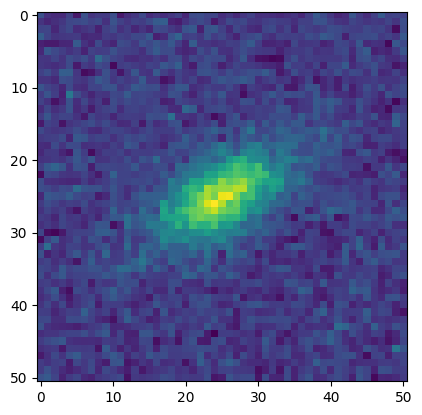

In [159]:
imshow(obs1.drawImage(nx=51,ny=51,scale=.1).array)

In [160]:
loss=create_loss(model=model,images=obs_ims,sky_level=sky_level,psfs=psfs,boxsize=51,scale=.1)

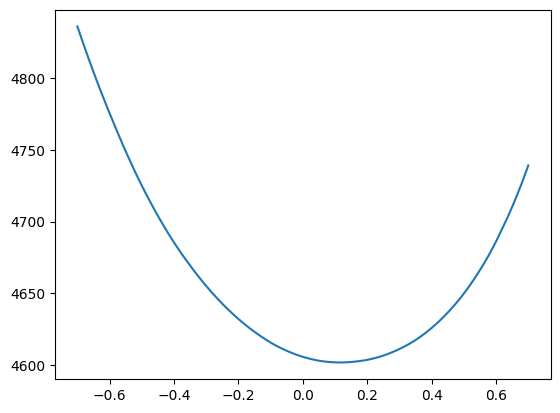

In [161]:
X = np.linspace(-.7,.7,2000)
Y = [loss(array([flu*.1,0.5,x,0])) for x in X]
plot(X,array(Y))

1383.8869366056988 0.35331256811507317 0.264339925133538 -0.5104677241772003


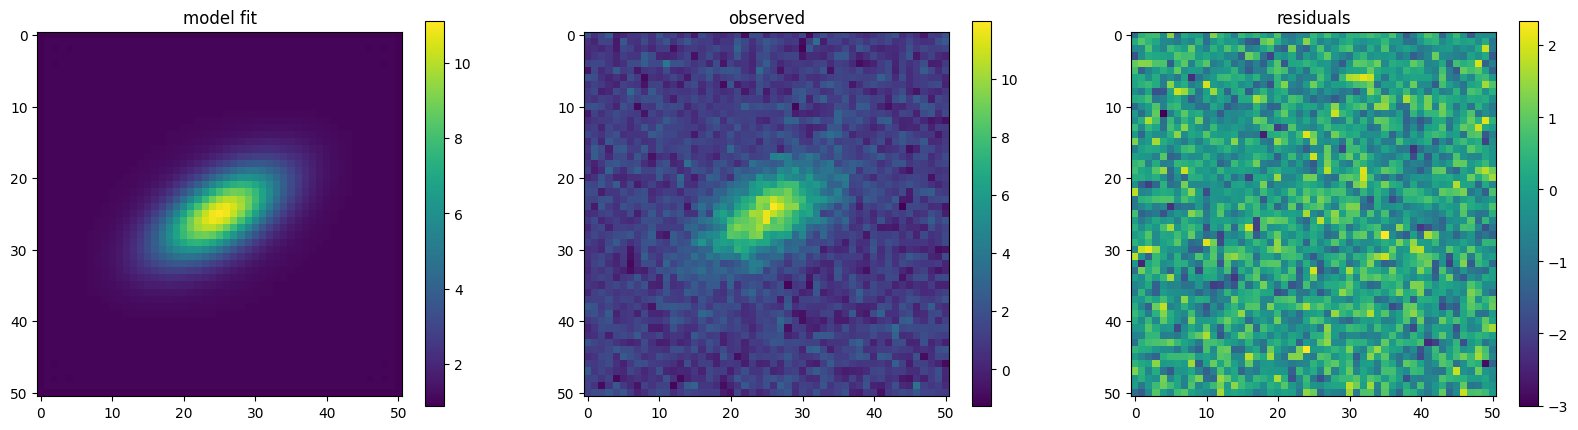

In [162]:
result=minimize(loss,x0=array([gal_flu,1.,0.,0.]),bounds=[(gal_flu*0.5,gal_flu*1.5),(.1,10.),(-.7,.7),(-.7,.7)],method='Nelder-Mead')
obsfit = model(*result.x,bkg=sky_level,psfs=[psf2],boxsize=51,scale=.1)[0]
figure(figsize=(20,5))
subplot(131)
title('model fit')
imshow(obsfit);colorbar()
subplot(132)
title('observed')
imshow(obs2.drawImage(nx=51,ny=51,scale=.1).array);colorbar()
subplot(133)
title('residuals')
imshow(obsfit-obs1.drawImage(nx=51,ny=51,scale=.1).array);colorbar()
print(*result.x)
savefig('somenoise.png',bbox_inches='tight')

## Create a basic metacal implementation

In [6]:
def get_metacal_type(deconv_gal,step,type_name):
  if type_name == "noshear":
    return deconv_gal.shear(0,0)
  elif type_name == "1p":
    return deconv_gal.shear(step,0) 
  elif type_name == "2p":
    return deconv_gal.shear(0,step)
  elif type_name == "1m":
    return deconv_gal.shear(-step,0)
  elif type_name == "2m":
    return deconv_gal.shear(0,-step)
  
def get_fixnoise(noise_image,step,type_name):
  sheared_noise = get_metacal_type(noise_image,step,type_name)
  galsimrot90 = galsim.Angle(90,galsim.AngleUnit(pi/180.))
  rotated_sheared_noise = sheared_noise.rotate(galsimrot90)
  return rotated_sheared_noise

def get_all_metacal(
  gal,
  psf,
  reconv_psf,
  noise_image=None,
  types=['noshear','1p','1m','2p','2m'],
  step=0.01
):
  
  inv_psf = galsim.Deconvolve(psf)
  deconv_gal = galsim.Convolve([gal,inv_psf])
  obsdict = {}
  for t in types:
    sheared_gal = get_metacal_type(deconv_gal,step,type_name=t)
    reconv_galaxy = galsim.Convolve([sheared_gal,reconv_psf])
    obsdict +={t: }#TODO
  
  if fixnoise== True:
  for t in types:
    sheared_gal = get_metacal_type(deconv_gal,step,type_name=t)
    reconv_galaxy = galsim.Convolve([sheared_gal,reconv_psf])
    obsdict +={t: }
    
  return obsdict 

SyntaxError: invalid syntax (162084492.py, line 15)

## Pujol Test

In [7]:
def pujol_sims(gal_model,psf_model,step=0.02):
  gal1p = gal.shear(step,0)
  gal2p = gal.shear(0,step)
  
  #noshear
  obsns = galsim.Convolve([gal,psf_model])
  #1p
  obs1p = galsim.Convolve([gal1p,psf_model])
  #2p
  obs2p = galsim.Convolve([gal2p,psf_model])
    
  pujobsdict = {
    'noshear':obsns,
    '1p':obs1p,
    '2p':obs2p,  
  }  
  return  pujobsdict

In [8]:
def apply_noise(pujobsdict,noise):
  for key in pujobsdict.keys():
    pujobsdict[key] += noise
  return pujobsdict

In [9]:
def measure_ellipticities(obsdict,method):
  resdict = {}
  for key in obsdict.keys():
    resdict += {key: method(pujobsdict[key])}
  return resdict

In [10]:
def get_metacal_response(resdict,shear_type = 'g'):
  '''gets the shear response for ngmix-like results'''

  #noshear
  g0s = np.array(resdict['noshear'][shear_type])
  
  #shear
  g1p = np.array(resdict['1p'][shear_type])
  g1m = np.array(resdict['1m'][shear_type])
  g2p = np.array(resdict['2p'][shear_type])
  g2m = np.array(resdict['2m'][shear_type])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,  
  } 
      
  return ellip_dict, R

def get_pujol_response(resdict):

  #noshear
  g0s = np.array(resdict['noshear'])
  
  #shear
  g1p = np.array(resdict['1p'])
  g2p = np.array(resdict['2p'])   
  
  R11 = (g1p[0]-g0s[0])/(2*step)
  R21 = (g1p[1]-g0s[1])/(2*step) 
  R12 = (g2p[0]-g0s[0])/(2*step)
  R22 = (g2p[1]-g0s[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,  
  } 
      
  return ellip_dict, R